This project analyzes a time series on petrol prices and creates a forecast using an LSTM RNN model.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
sns.set_style('whitegrid')

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
df = pd.read_csv("/content/drive/MyDrive/Projects/Deploy/Petrol Price Forecasting/Project Code and Files/train_data.csv")
df.head()

,Date,Petrol (USD)
0,6/9/2003,74.59
1,6/16/2003,74.47
2,6/23/2003,74.42
3,6/30/2003,74.35
4,7/7/2003,74.28


In [6]:
df.isnull().sum()

Date            0
Petrol (USD)    2
dtype: int64

In [7]:
df.shape

(813, 2)

In [8]:
df = df.dropna()
df.shape

(811, 2)

In [9]:
df = df.set_index(pd.DatetimeIndex(df['Date']))

In [10]:
df.rename(columns={"Petrol (USD)": "Petrol"}, inplace = True)
df = df.drop('Date', axis=1)
df.head()

,Petrol
Date,
2003-06-09,74.59
2003-06-16,74.47
2003-06-23,74.42
2003-06-30,74.35
2003-07-07,74.28


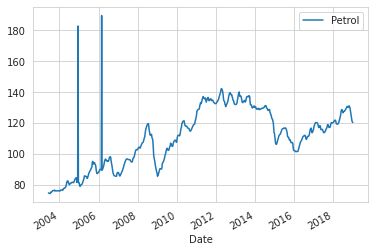

In [11]:
df.plot()

In [12]:
# remove outlier prices
df=df[df.Petrol<160]

In [13]:
df

,Petrol
Date,
2003-06-09,74.59
2003-06-16,74.47
2003-06-23,74.42
2003-06-30,74.35
2003-07-07,74.28
...,...
2018-12-03,124.30
2018-12-10,122.37
2018-12-17,121.02


# Time Series Analysis

In [14]:
# Interactive Time Series plot of Petrol Price
 
fig = px.line(df, y='Petrol', x=df.index, title='Petrol Time Series')
fig.update_layout(xaxis_title='Date')
fig.show()

In [15]:
from numpy import polyfit
def fit(X, y, degree=3):
    coef = polyfit(X, y, degree)
    trendpoly = np.poly1d(coef)
    return trendpoly(X)
def get_season(s, yearly_periods=52, degree=3):
    X = [i%(yearly_periods) for i in range(0, len(s))]
    seasonal = fit(X, s.values, degree)
    return pd.Series(data=seasonal, index=s.index)
def get_trend(s, degree=3):
    X = list(range(len(s)))
    trend = fit(X, s.values, degree)
    return pd.Series(data=trend, index=s.index)

Text(0, 0.5, 'Petrol')

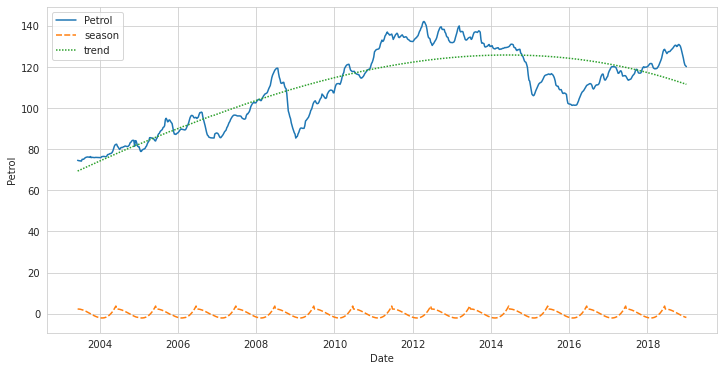

In [16]:
# Plot trend and seasonality

data = df.copy()
plt.figure(figsize=(12, 6))
data['trend'] = get_trend(data['Petrol'])
data['season'] = get_season(data['Petrol'] - data['trend'])
sns.lineplot(data=data[['Petrol', 'season', 'trend']])
plt.ylabel('Petrol')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



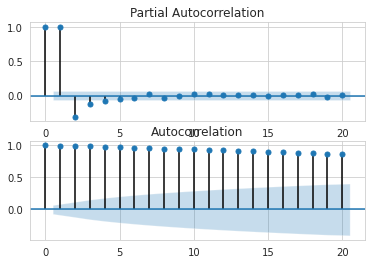

In [17]:
# correlation of each lag
import statsmodels.api as sm
fig, axes = plt.subplots(nrows=2, ncols=1)
sm.graphics.tsa.plot_pacf(data['Petrol'], lags=20, ax=axes[0]);
sm.graphics.tsa.plot_acf(data['Petrol'], lags=20, ax=axes[1]);

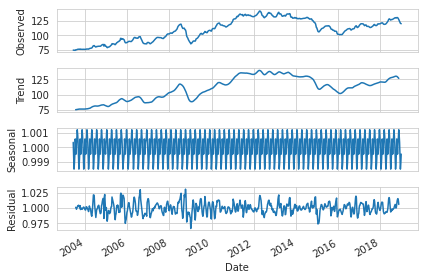

In [18]:
# trend and seasonality with statsmodel
from statsmodels.tsa.seasonal import seasonal_decompose
DecompDataAdd = seasonal_decompose(data['Petrol'], model='multiplicative', freq=12)
DecompDataAdd.plot();

## EDA with Dash

In [ ]:
!pip install jupyter-dash
!pip install pyngrok

In [20]:
import plotly.graph_objs as go
fig = go.Figure([
    go.Scatter(
        name='Petrol',
        x=data.index,
        y=data['Petrol'],
        mode='lines',
        marker=dict(color='blue', size=2),
        showlegend=True
    ),
    go.Scatter(
        name='Trend',
        x=data.index,
        y=data['trend'],
        mode='lines',
        marker=dict(color='green', size=1),
        showlegend=True
    ),
    go.Scatter(
        name='Season',
        x=data.index,
        y=data['season'],
        marker=dict(color="orange"),
        line=dict(width=1),
        mode='lines',
        showlegend=True
    )
])
fig.update_layout(
    yaxis_title='Petrol',
    title='Petrol Time Series',
    hovermode="x"
)

In [21]:
# Dashboard with Dash
 
from jupyter_dash import JupyterDash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
from pyngrok import ngrok
 
app = JupyterDash(__name__)
 
app.layout = html.Div([
    dcc.Graph(figure=fig)
])
 
app.run_server(mode='external')

Dash app running on:


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning:


The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from dash import dcc`

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning:


The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`



<IPython.core.display.Javascript object>

In [22]:
! ngrok authtoken 1vXlcIP1hk2NmY9UBuuSHU5gLHX_72emhyJmaGcTmoF6TQfKk

Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


In [23]:
public_url = ngrok.connect(addr = '8050')

In [24]:
public_url

<NgrokTunnel: "http://0aae-34-91-180-183.ngrok.io" -> "http://localhost:8050">

In [25]:
ngrok.kill()

# RNN Model

## Scale and Split

In [26]:
len(df)

809

In [27]:
test_size = 24
test_ind = len(df)- test_size # test index

In [28]:
train = df.iloc[:test_ind] # training set
test = df.iloc[test_ind:] # testing set is last 24 values

In [29]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train)

MinMaxScaler()

In [30]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

# Time Series Generator

In [31]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [32]:
length = 24
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=1)

## Create the LSTM Model

In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [34]:
n_features = 1

In [35]:
model = Sequential()
model.add(LSTM(55, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [36]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 55)                12540     
                                                                 
 dense (Dense)               (None, 1)                 56        
                                                                 
Total params: 12,596
Trainable params: 12,596
Non-trainable params: 0
_________________________________________________________________


In [37]:
validation_generator = TimeseriesGenerator(scaled_test,scaled_test, length=20, batch_size=1)

In [38]:
from tensorflow.keras.callbacks import EarlyStopping

In [39]:
early_stop = EarlyStopping(monitor='val_loss',patience=3)

In [40]:
model.fit_generator(generator,epochs=25,
                    validation_data=validation_generator,
                   callbacks=[early_stop])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



Epoch 1/25
761/761 [==============================] - 7s 7ms/step - loss: 0.0099 - val_loss: 0.0032
Epoch 2/25
761/761 [==============================] - 5s 7ms/step - loss: 0.0018 - val_loss: 4.1155e-04
Epoch 3/25
761/761 [==============================] - 5s 7ms/step - loss: 0.0010 - val_loss: 0.0013
Epoch 4/25
761/761 [==============================] - 5s 7ms/step - loss: 7.0744e-04 - val_loss: 4.1529e-04
Epoch 5/25
761/761 [==============================] - 5s 7ms/step - loss: 5.5957e-04 - val_loss: 3.6086e-04
Epoch 6/25
761/761 [==============================] - 6s 7ms/step - loss: 4.7830e-04 - val_loss: 2.3322e-04
Epoch 7/25
761/761 [==============================] - 5s 7ms/step - loss: 4.1193e-04 - val_loss: 4.1612e-04
Epoch 8/25
761/761 [==============================] - 5s 7ms/step - loss: 4.0661e-04 - val_loss: 4.1788e-04
Epoch 9/25
761/761 [==============================] - 5s 7ms/step - loss: 3.7005e-04 - val_loss: 1.3898e-04
Epoch 10/25
761/761 [===========================

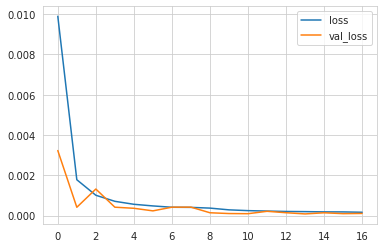

In [41]:
losses = pd.DataFrame(model.history.history)
losses.plot()

## Evaluate on Test Data

In [42]:
test_predictions = []
 
first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))
 
for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [43]:
true_predictions = scaler.inverse_transform(test_predictions)

In [44]:
test['Predictions'] = true_predictions

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [45]:
test

,Petrol,Predictions
Date,,
2018-07-23,127.50,127.161638
2018-07-30,127.54,126.432474
2018-08-06,128.02,125.333211
2018-08-13,128.39,124.140315
2018-08-20,128.79,122.892106
2018-08-27,129.18,121.601235
2018-09-03,129.76,120.283864
2018-09-10,130.24,118.957748
2018-09-17,130.59,117.638980


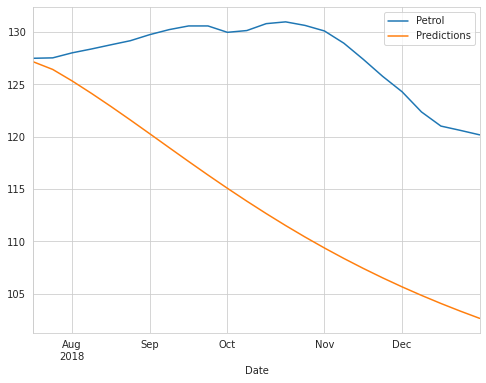

In [46]:
test.plot(figsize=(8,6))

In [47]:
from sklearn import metrics

In [48]:
# Evaluate test data predictions vs actual test data
print('RMSE:', np.sqrt(metrics.mean_squared_error(test['Petrol'], test['Predictions'])))

RMSE: 15.116886168208316


## Forecast

In [49]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [50]:
length = 24 # Length of the output sequences (in number of timesteps)
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length=length, batch_size=1)

In [51]:
model = Sequential()
model.add(LSTM(55, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# fit model
model.fit_generator(generator,epochs=8)

Epoch 1/8


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



785/785 [==============================] - 7s 7ms/step - loss: 0.0115
Epoch 2/8
785/785 [==============================] - 6s 7ms/step - loss: 0.0015
Epoch 3/8
785/785 [==============================] - 5s 7ms/step - loss: 8.4600e-04
Epoch 4/8
785/785 [==============================] - 6s 7ms/step - loss: 7.1416e-04
Epoch 5/8
785/785 [==============================] - 6s 7ms/step - loss: 4.8391e-04
Epoch 6/8
785/785 [==============================] - 5s 7ms/step - loss: 5.4778e-04
Epoch 7/8
785/785 [==============================] - 5s 7ms/step - loss: 4.6262e-04
Epoch 8/8
785/785 [==============================] - 6s 7ms/step - loss: 3.3486e-04


In [52]:
forecast = []
# Replace periods with forecast length
periods = 12 # Forecast out 12 weeks
 
first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))
 
for i in range(periods):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    forecast.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [53]:
forecast = scaler.inverse_transform(forecast)

In [54]:
forecast_index = pd.date_range(start='2019-01-07',periods=periods,freq='W')

In [55]:
forecast_df = pd.DataFrame(data=forecast,index=forecast_index,
                           columns=['Forecast'])

In [56]:
forecast_df

,Forecast
2019-01-13,119.022070
2019-01-20,118.435106
2019-01-27,117.759716
2019-02-03,117.065979
2019-02-10,116.367184
2019-02-17,115.671069
2019-02-24,114.983482
2019-03-03,114.308460
2019-03-10,113.648811
2019-03-17,113.006198


In [57]:
Forecast = pd.concat([df, forecast_df])

In [58]:
Forecast

,Petrol,Forecast
2003-06-09,74.59,NaN
2003-06-16,74.47,NaN
2003-06-23,74.42,NaN
2003-06-30,74.35,NaN
2003-07-07,74.28,NaN
...,...,...
2019-03-03,NaN,114.308460
2019-03-10,NaN,113.648811
2019-03-17,NaN,113.006198
2019-03-24,NaN,112.381786


In [59]:
# Plot of previous and forecasted data

import plotly.graph_objects as go

fig2 = go.Figure()
fig2.add_trace(go.Scatter(x=Forecast.index, y=Forecast['Petrol'],
                    mode='lines',
                    name='Petrol'))
fig2.add_trace(go.Scatter(x=Forecast.index, y=Forecast['Forecast'],
                    mode='lines',
                    name='Forecast'))